### Analyses of output files from the pipeline optimus v6.0.0+
#### Aim of this part of analysis is to realize the Feature selection

#### Load necessary libraries and useful functions

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext rpy2.ipython

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore") 

#### Data Loading

In [30]:
input_h5ad = "../scAtlas/tmp/10k_pbmc_v3_out_normalize.h5ad"
adata = sc.read_h5ad(input_h5ad)

In [4]:
display(adata)

AnnData object with n_obs × n_vars = 10214 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'scDblFinder_score', 'scDblFinder_class', 'S_score', 'G2M_score', 'phase'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_tes

###### check barcode and gene names

In [5]:
display(adata.var_names)
display(adata.obs_names)

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'AL627309.6', 'OR4G11P', 'OR4F5', 'AL627309.1',
       ...
       'pRNA-11', 'RNA5-8S5', 'pRNA-12', 'RNA5-8SN2', 'AC007325.3',
       'AC007325.1', 'AC007325.4', 'AC007325.2', 'U6-36', 'U1-15'],
      dtype='object', name='gene_name', length=58347)

Index(['CAGAGCCTCTTCGATT', 'TACATTCTCCGTAGTA', 'ATCACGAAGGGACACT',
       'ATCTTCATCCCGAATA', 'TGTTACTTCTACAGGT', 'CCGGTAGTCACGACTA',
       'TTCGGTCCAGTTGTCA', 'ATCCACCAGTAGGAAG', 'TGTGCGGCATTCCTAT',
       'ACTATCTCATAACGGG',
       ...
       'CTTTCGGAGATCGCTT', 'CCCTCTCCACAGCTTA', 'CCACAAAAGCGTCTCG',
       'TTCTGTACAGCAGTTT', 'CACCGTTCAATCCTAG', 'CCTAAGACAGCGAACA',
       'CTCCTTTGTACAGTTC', 'CCTACGTAGCACCTGC', 'GAGGGATAGTAAACGT',
       'TATTGGGGTCATACCA'],
      dtype='object', name='barcode', length=10214)

In [31]:
adata.raw = adata.copy()

#### Feature selection

scanpy

In [ ]:
"""
# alix's code
genes_info = sc.pp.highly_variable_genes(adata, inplace=False)
adata.var["highly_variable"] = genes_info[
    "highly_variable"
].to_numpy()  # The to_numpy is here to allow assignation without an index
"""

In [32]:
# Add {'base': None} in adata.uns['log1p'], else sc.pp.highly_variable_genes bug
adata.uns['log1p'] = {'base': None}

In [36]:
# identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, layer="log1p_norm", inplace=True)

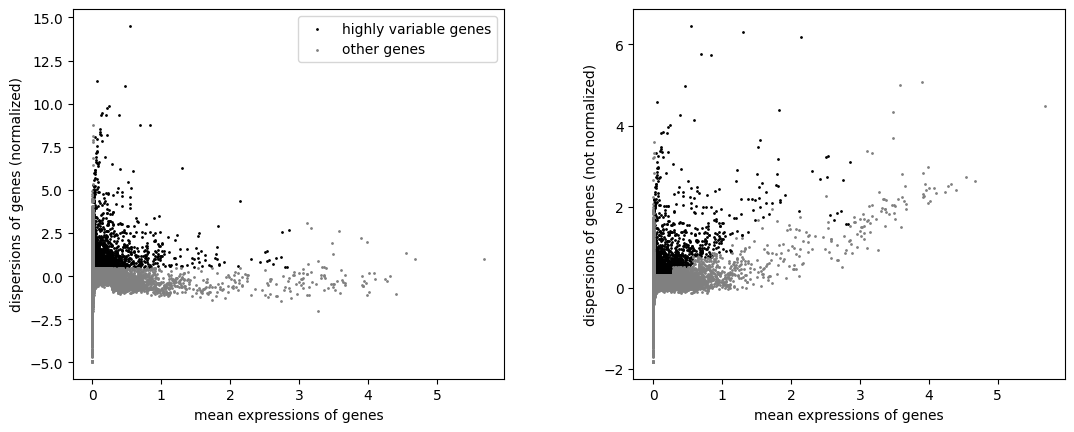

In [37]:
sc.pl.highly_variable_genes(adata) #sc.pl.highly_variable_genes(adata, save='_HVG.pdf')

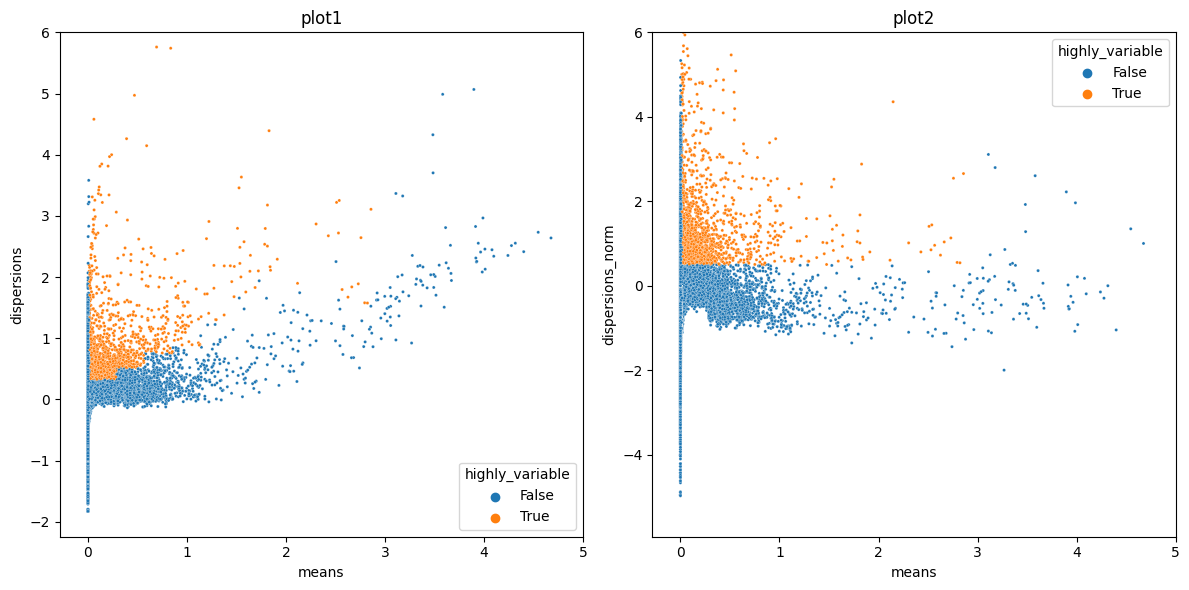

In [39]:
# visualization: using sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatterplot on the left
sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_variable", s=5, ax=ax1)
ax1.set_xlim(None, 5)
ax1.set_ylim(None, 6)
ax1.set_title("plot1")

# Plot the second scatterplot on the right
sns.scatterplot(data=adata.var, x="means", y="dispersions_norm", hue="highly_variable", s=5, ax=ax2)
ax2.set_xlim(None, 5)
ax2.set_ylim(None, 6)
ax2.set_title("plot2")

plt.tight_layout()
plt.show()


scry

for scanpy: to see if we need

In [90]:
# save row adata
adata.raw = adata
# keeping only the highly variable genes
adata = adata[:, adata.var.highly_variable]

In [ ]:
# 将数据缩放到单位方差
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# 保存数据
results_file = './data/pbmc3k_processed.h5ad'
adata.write(results_file)

In [12]:
seed = 22

#### Write output to h5ad

In [18]:
PATH_TO_OUTPUT = "../scAtlas/tmp/10k_pbmc_v3_out_normalize.h5ad"
adata.write_h5ad(PATH_TO_OUTPUT)